In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
dj.config['database.host'] = 'datajoint.mesoscale-activity-map.org'
dj.config['database.user'] = 'pochen'
dj.config['database.password'] = 'simple'

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

Connecting pochen@datajoint.mesoscale-activity-map.org:3306


# Plan
### Fetch population data
### Coding dimension analysis
### dsPCA

## Fetch population data

In [2]:
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:10]

,count
annotation,
"Lateral septal nucleus, rostral (rostroventral) part",801
Caudoputamen,473
"Secondary motor area, layer 6a",401
"Secondary motor area, layer 5",294
"Prelimbic area, layer 5",286
Ventral medial nucleus of the thalamus,285
"Anterior cingulate area, dorsal part, layer 5",276
"Lateral septal nucleus, ventral part",273
"Anterior cingulate area, ventral part, layer 5",230


In [3]:
def select_unit_qc_region(all_unit_qc, region="Prelimbic%"):
    return (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region)

def select_unit_qc_region_mouse_session(all_unit_qc, region="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)


# unit_qc_prelimbic = select_unit_qc_region(all_unit_qc)
unit_qc_prelimbic_HH09_session47 = select_unit_qc_region_mouse_session(all_unit_qc)
len(unit_qc_prelimbic_HH09_session47)


# select all QC-filtered prelimbic units
# unit_qc_prelimbic = (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "Prelimbic%"'

# select all QC-filtered prelimbic units for Mouse HH09 in Session 47.
# unit_qc_prelimbic_HH09_session47 = unit_qc_prelimbic & (lab.WaterRestriction & 'water_restriction_number = "HH09"') & 'session = 47'
# len(unit_qc_prelimbic_HH09_session47)

58

In [4]:
# fetch population activities

# unit_qc_prelimbic_HH09_session47
keys2units = unit_qc_prelimbic_HH09_session47.fetch('KEY')
# keys2units_L = (unit_qc_prelimbic_HH09_session47 & '').fetch('KEY')
print('num of units: {}'.format(len(keys2units)))

# check the laterality of units
hemi = util._get_units_hemisphere(keys2units)
print('laterality: {}'.format(hemi))


# fetch trials in the session
# print(psth_foraging.TrialCondition().fetch('trial_condition_name'))
# psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
keys2trials_all = (psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units).fetch('KEY')
trials_all = psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
print('num of all trials: {}'.format(len(keys2trials_all)))


keys2trials_hit = (psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units).fetch('KEY')
trials_hit = psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units
print('num of hit trials: {}'.format(len(keys2trials_hit)))

keys2trials_miss = (psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units).fetch('KEY')
trials_miss = psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units
print('num of miss trials: {}'.format(len(keys2trials_miss)))


keys2trials_L = (psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units).fetch('KEY')
trials_L = psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units
print('num of left trials: {}'.format(len(keys2trials_L)))

keys2trials_R = (psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units).fetch('KEY')
trials_R = psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units
print('num of right trials: {}'.format(len(keys2trials_R)))

num of units: 58
laterality: right
num of all trials: 408
num of hit trials: 135
num of miss trials: 273
num of left trials: 233
num of right trials: 175


In [14]:
def gen_psth_per_trial(keys2units, trials, align_type='iti_start'):
    
    pop_psth_per_trial = []
    trial_ind = []
    bins = None
    for key in keys2units:
        unit_psth_raster = psth_foraging.compute_unit_psth_and_raster(key, trials, align_type)
        unit_psth_per_trial = unit_psth_raster['psth_per_trial']  # (trial, time_step)
        pop_psth_per_trial.append(unit_psth_per_trial)
        if bins is None:
            bins = unit_psth_raster['bins']
    pop_psth_per_trial = np.array(pop_psth_per_trial)
    print('bins: {}'.format(bins.shape))
    print('population psth per trial: {}'.format(pop_psth_per_trial.shape))

    return bins, pop_psth_per_trial


def get_psth_by_trial_type_index(pop_psth, all_trial_ind, select_trial_ind):
    
    select_index = np.where(np.in1d(all_trial_ind, select_trial_ind))[0]
    pop_psth_selected_trial = pop_psth[:, select_index, :]
    print('check: sel trial ind {}, output pop psth {}'.format(select_trial_ind.shape, pop_psth_selected_trial.shape))
    
    return pop_psth_selected_trial


bins, pop_psth_all = gen_psth_per_trial(keys2units, trials_all)  # (unit, trial, time_step)

all_trial_ind = np.array(trials_all.fetch('trial'))
hit_trial_ind = np.array((trials_all & 'outcome="hit"').fetch('trial'))
miss_trial_ind = np.array((trials_all & 'outcome="miss"').fetch('trial'))
left_trial_ind = np.array((trials_all & 'water_port="left"').fetch('trial'))
right_trial_ind = np.array((trials_all & 'water_port="right"').fetch('trial'))

pop_psth_hit = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, hit_trial_ind)
pop_psth_miss = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, miss_trial_ind)

pop_psth_L = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, left_trial_ind)
pop_psth_R = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, right_trial_ind)

bins: (324,)
population psth per trial: (58, 408, 324)
check: sel trial ind (135,), output pop psth (58, 135, 324)
check: sel trial ind (273,), output pop psth (58, 273, 324)
check: sel trial ind (233,), output pop psth (58, 233, 324)
check: sel trial ind (175,), output pop psth (58, 175, 324)


In [11]:
pop_psth_counts = np.average(pop_psth_all, axis=2)

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

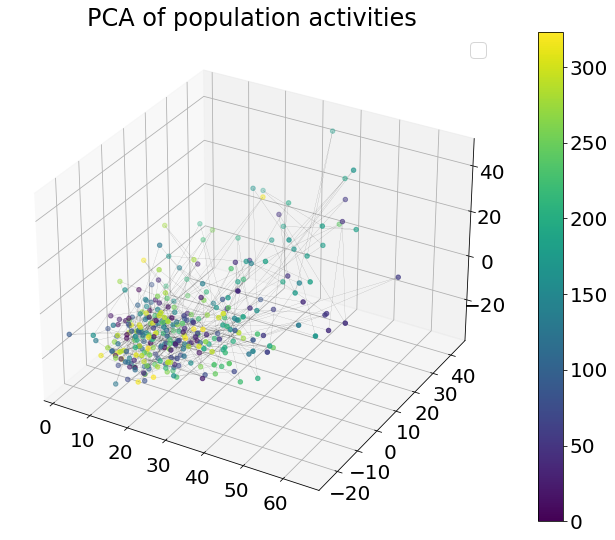

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

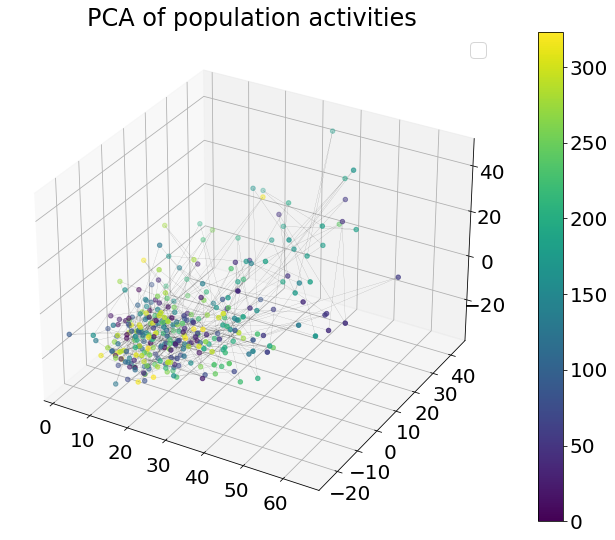

In [50]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def pop_counts_pca(pop_psth_avg, cluster_crtieria, verbose=True):
    
    colors = ["navy", "turquoise"]
    lw = 0.01
    
    if cluster_crtieria == 'water_port':
        target_names = ['L', 'R']
        selected_indices = [np.where(np.in1d(all_trial_ind, left_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, right_trial_ind))[0]]
    elif cluster_crtieria == 'outcome':
        target_names = ['hit', 'miss']
        selected_indices = [np.where(np.in1d(all_trial_ind, hit_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, miss_trial_ind))[0]]
    else:
        raise ValueError('cluster_criteria ill defined')

    pca = PCA(n_components=3)
    X = pop_psth_avg.transpose()   # (trial, units)
    pca.fit(X)
    print(pca.components_)
    print(pca.explained_variance_)
    X_pca = pca.transform(X)     # (trial, n_feature)

    X_pca_all_time = []
    for i in range(pop_psth_all.shape[2]):
        _X_pca = pca.transform(pop_psth_all[:, :, i].transpose())
        X_pca_all_time.append(_X_pca)
    X_pca_all_time = np.array(X_pca_all_time)

    if verbose:
        print('reduced matrix shape: {}'.format(X_pca_all_time.shape))
        print(X_pca_all_time[:, 0, 0])
        # Percentage of variance explained for each components
        print("explained variance ratio (first two components): %s" % str(pca.explained_variance_ratio_))

    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(111, projection='3d')
    # ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)
    t = np.arange(X_pca_all_time.shape[0])

    plot_ind = 9
    p = ax.scatter(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
                   c=t, cmap='viridis')
    ax.plot(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
            'k--', lw=0.1)
    
    # for color, ind, target_name in zip(colors, selected_indices, target_names):
    #     ax.scatter(X_pca_all_time[:, ind, 0], X_pca_all_time[:, ind, 1], X_pca_all_time[:, ind, 2],
    #                color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="best")
    fig.colorbar(p)
    plt.title("PCA of population activities")
    plt.show()

pop_counts_pca(pop_psth_counts, 'outcome')
pop_counts_pca(pop_psth_counts, 'water_port')

In [22]:
# fetch independent variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable
                    & keys2trials
                    & {'model_id': 10})
q_latent_variable

# fetch independent variables?
df = util._get_unit_independent_variable(keys2trials[0], model_id=10)
df


Coding Axes

(58, 175, 324)
(58, 233, 324)


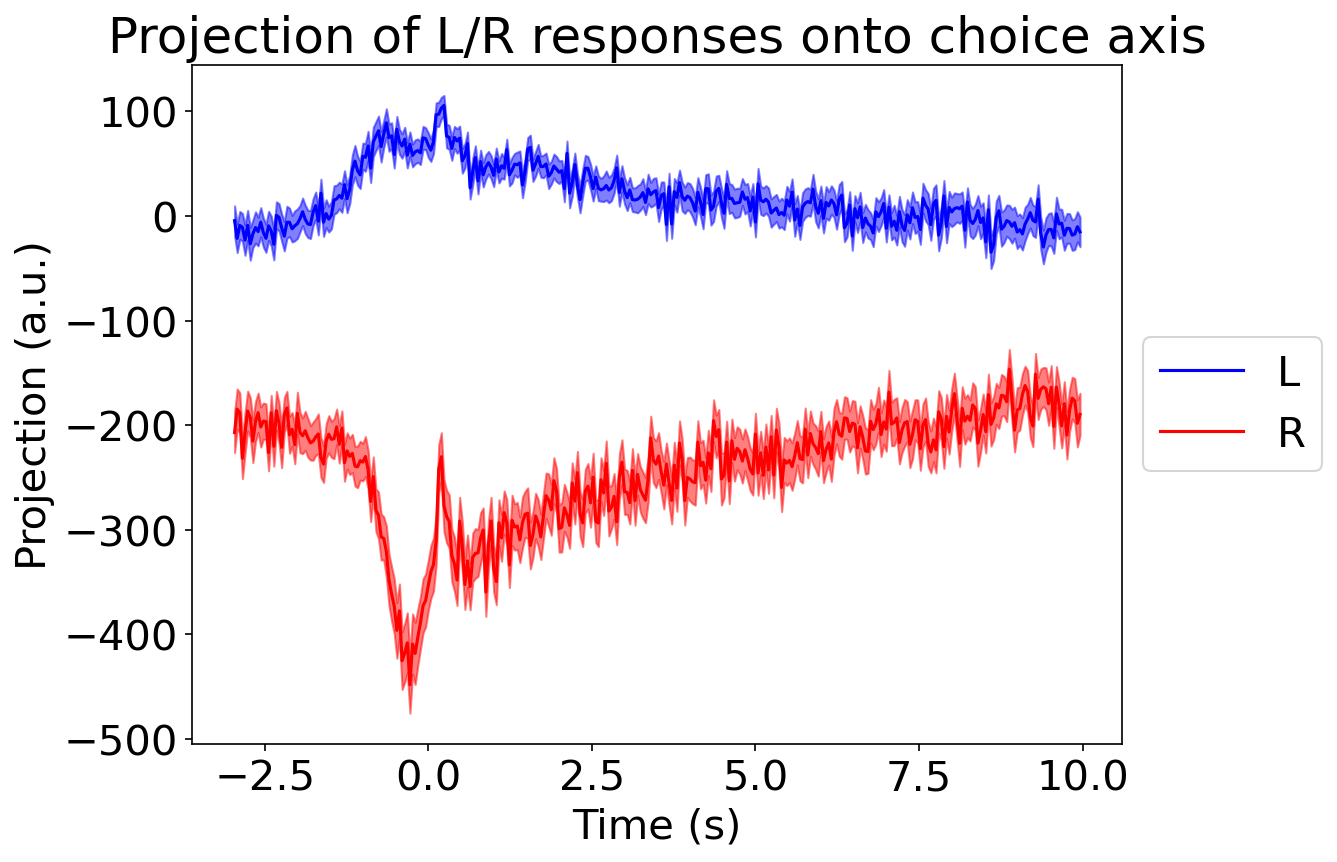

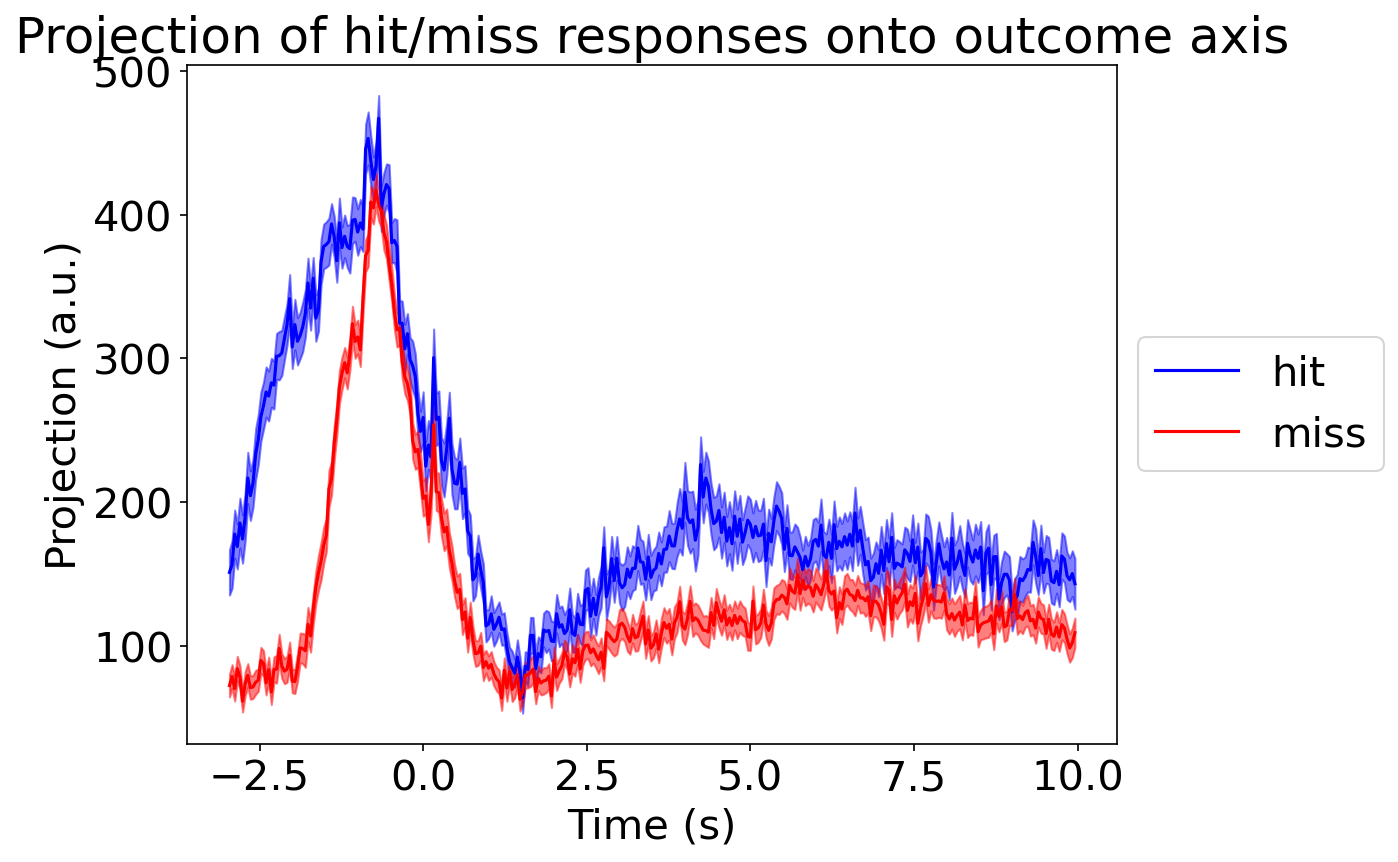

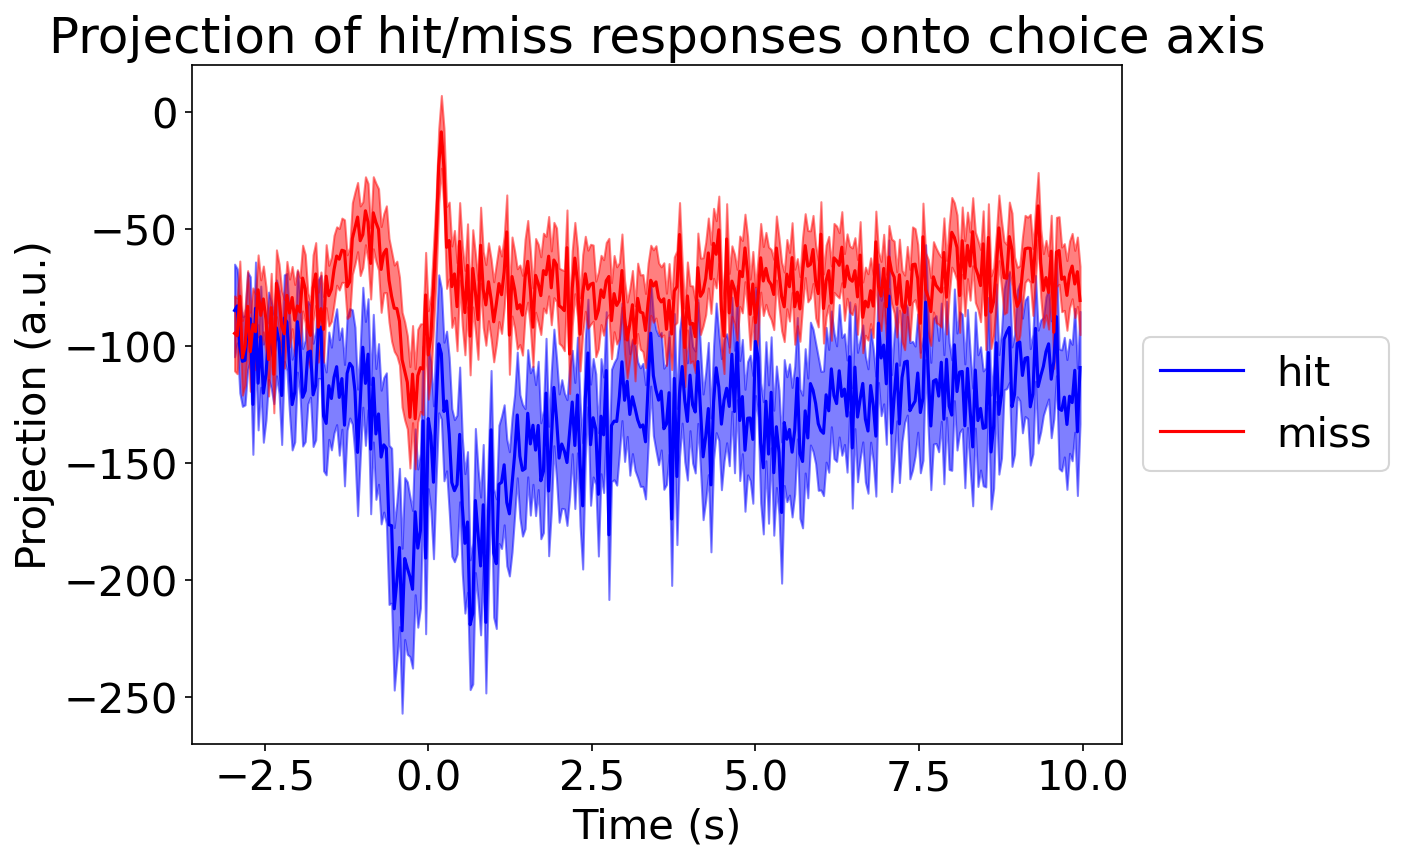

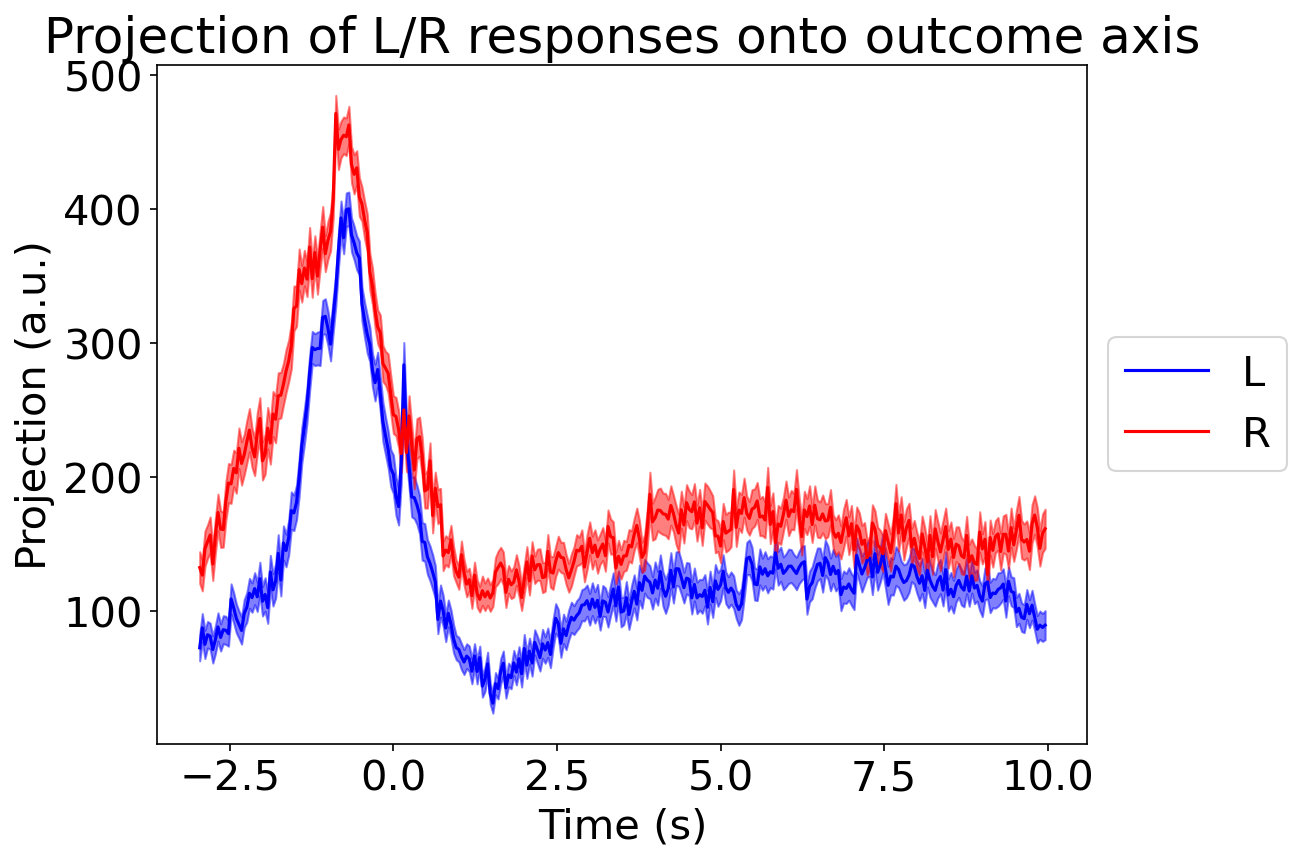

In [19]:
def get_coding_axis(pop_psth_1, pop_psth_2):

    pop_psth_1_avg = np.average(pop_psth_1, axis=1)
    pop_psth_2_avg = np.average(pop_psth_2, axis=1)
    pop_psth_diff_12 = pop_psth_1_avg - pop_psth_2_avg
    pop_psth_diff_12_avg = np.average(pop_psth_diff_12, axis=1)

    return pop_psth_diff_12_avg


def get_coding_axis_projection(pop_psth, coding_axis):
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_axis)
    proj_avg = np.average(proj, axis=0)
    proj_std = np.std(proj, axis=0)
    proj_sem = proj_std / np.sqrt(proj.shape[0])

    return proj_avg, proj_sem
    

def plot_projection_coding_axis(proj_1, proj_1_sem, proj_2, proj_2_sem, bins,
                                proj_1_source_name, proj_2_source_name, axis_name):
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150) 
    plt.plot(bins, proj_1, 'b-', label=proj_1_source_name)
    plt.fill_between(bins, proj_1-proj_1_sem, proj_1+proj_1_sem,
                    alpha=0.5, color='b')
    plt.plot(bins, proj_2, 'r-', label=proj_2_source_name)
    plt.fill_between(bins, proj_2-proj_2_sem, proj_2+proj_2_sem,
                    alpha=0.5, color='r')
    plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


print(pop_psth_R.shape)
print(pop_psth_L.shape)

choice_coding_axis = get_coding_axis(pop_psth_L, pop_psth_R)
L_proj_choice_axis, L_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_L, choice_coding_axis)
R_proj_choice_axis, R_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_R, choice_coding_axis)
plot_projection_coding_axis(L_proj_choice_axis, L_proj_choice_axis_sem, R_proj_choice_axis, R_proj_choice_axis_sem, bins,
                            'L', 'R', 'choice')

outcome_coding_axis = get_coding_axis(pop_psth_hit, pop_psth_miss)
hit_proj_outcome_axis, hit_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_hit, outcome_coding_axis)
miss_proj_outcome_axis, miss_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_miss, outcome_coding_axis)
plot_projection_coding_axis(hit_proj_outcome_axis, hit_proj_outcome_axis_sem, miss_proj_outcome_axis, miss_proj_outcome_axis_sem, bins,
                            'hit', 'miss', 'outcome')

hit_proj_choice_axis, hit_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_hit, choice_coding_axis)
miss_proj_choice_axis, miss_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_miss, choice_coding_axis)
plot_projection_coding_axis(hit_proj_choice_axis, hit_proj_choice_axis_sem, miss_proj_choice_axis, miss_proj_choice_axis_sem, bins,
                            'hit', 'miss', 'choice')

L_proj_outcome_axis, L_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_L, outcome_coding_axis)
R_proj_outcome_axis, R_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_R, outcome_coding_axis)
plot_projection_coding_axis(L_proj_outcome_axis, L_proj_outcome_axis_sem, R_proj_outcome_axis, R_proj_outcome_axis_sem, bins,
                            'L', 'R', 'outcome')